In [8]:
# delete this cell if working on Pycharm
!pip install Bio
!pip install import-ipynb

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os

print(os.listdir("/content/drive/MyDrive/Ex4Files"))

['Ex4Data', '6xw6', 'model_loss_history.png', 'trained_model.keras', 'utils.ipynb', 'train_labels.npy', 'train_input.npy', 'net.ipynb']


In [11]:
print(os.listdir("/content/drive/MyDrive/Ex4Files/Ex4Data"))

['7jmo.pdb', '7bei.pdb', '6QV1_1.pdb', '5SV4_1.pdb', '5VK2_1.pdb', '5IBL_1.pdb', '6z20.pdb', '4X0K_1.pdb', '2UZI_1.pdb', '6uuh.pdb', '2NYY_1.pdb', '5YFI_1.pdb', '6z7z.pdb', '2HH0_1.pdb', '5OCL_2.pdb', '1P4B_1.pdb', '7det.pdb', '1MVF_1.pdb', '2B1H_1.pdb', '5JDS_1.pdb', '4O02_1.pdb', '6DW2_1.pdb', '1FJ1_1.pdb', '5I1D_2.pdb', '6EAY_1.pdb', '3GBN_1.pdb', '4KI5_1.pdb', '2VXQ_1.pdb', '6QTL_1.pdb', '5JO4_2.pdb', '7ce2.pdb', '1FOR_1.pdb', '1A0Q_1.pdb', '5KVD_1.pdb', '6ztd.pdb', '6xtg.pdb', '4S1D_1.pdb', '5WI9_1.pdb', '1ZTX_1.pdb', '6osv.pdb', '4TSB_1.pdb', '7kgv.pdb', '5J13_1.pdb', '5USF_1.pdb', '3I2C_1.pdb', '5X4G_1.pdb', '6APQ_1.pdb', '5VLP_1.pdb', '4LVN_1.pdb', '4M61_1.pdb', '2VYR_1.pdb', '4PB0_1.pdb', '6DB6_1.pdb', '2FL5_1.pdb', '6DG2_1.pdb', '5AWN_1.pdb', '1OHQ_1.pdb', '4JPI_2.pdb', '2W9D_1.pdb', '3SDY_1.pdb', '6MTO_1.pdb', '4NJ9_1.pdb', '1C5C_1.pdb', '5UEA_1.pdb', '4HJ0_1.pdb', '6ITC_2.pdb', '6w00.pdb', '6C6Z_1.pdb', '4U3X_1.pdb', '3WSQ_1.pdb', '4NPY_2.pdb', '3N9G_1.pdb', '1A14_1.pdb', '

In [12]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path
%cd "/content/drive/MyDrive/Ex4Files/"
import import_ipynb
import utils

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/content/drive/MyDrive/Ex4Files
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Ex4Data', '6xw6', 'model_loss_history.png', 'trained_model.keras', 'utils.ipynb', 'train_labels.npy', 'train_input.npy', 'net.ipynb']


In [13]:
###############################################################################
#                                                                             #
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################


# number of ResNet blocks for the first ResNet and the kernel size.
RESNET_1_BLOCKS = 3
RESNET_1_KERNEL_SIZE = 15
RESNET_1_KERNEL_NUM = 64


###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 1
RESNET_2_KERNEL_SIZE = 3  # good start may be 3/5
RESNET_2_KERNEL_NUM = 48
DILATION = [1,2]

# percentage of dropout for the dropout layer
DROPOUT = 0.3 # good start may be 0.1-0.5

# number of epochs, Learning rate and Batch size
EPOCHS = 500
LR = 0.0001 # good start may be 0.0001/0.001/0.01
BATCH = 64 # good start may be 32/64/128

In [14]:
def resnet_1(input_layer):
    """
    ResNet layer - input -> BatchNormalization -> Conv1D -> Relu -> BatchNormalization -> Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_1_BLOCKS):
        batch_norm_layer = layers.BatchNormalization()(input_layer)
        conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same')(batch_norm_layer)
        batch_norm_layer = layers.BatchNormalization()(conv1d_layer)
        input_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same')(batch_norm_layer) + input_layer
    return input_layer


In [15]:
def resnet_2(input_layer):  # TODO: implement this!
    """
    Dilated ResNet layer - input -> BatchNormalization -> dilated Conv1D -> Relu -> BatchNormalization -> dilated Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    x = input_layer
    for _ in range(RESNET_2_BLOCKS):
        for dilation_rate in DILATION:
            shortcut = x  # Save input for skip connection

            # First Conv block with dilation
            x = layers.BatchNormalization()(x)
            x = layers.Conv1D(filters=RESNET_2_KERNEL_NUM,
                              kernel_size=RESNET_2_KERNEL_SIZE,
                              dilation_rate=dilation_rate,
                              padding='same')(x)
            x = layers.ReLU()(x)

            # Second Conv block with same dilation
            x = layers.BatchNormalization()(x)
            x = layers.Conv1D(filters=RESNET_2_KERNEL_NUM,
                              kernel_size=RESNET_2_KERNEL_SIZE,
                              dilation_rate=dilation_rate,
                              padding='same')(x)
            x = layers.ReLU()(x)

            # Add the skip connection
            x = layers.Add()([shortcut, x])

    return x

In [16]:
def build_network():
    """
    builds the neural network architecture as shown in the exercise.
    :return: a Keras Model
    """
    # input, shape (NB_MAX_LENGTH,FEATURE_NUM)
    input_layer = tf.keras.Input(shape=(utils.NB_MAX_LENGTH, utils.FEATURE_NUM))

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(input_layer)

    # first ResNet -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    resnet_layer = resnet_1(conv1d_layer)

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, padding="same")(resnet_layer)

    # second ResNet -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    resnet_layer = resnet_2(conv1d_layer)

    # Dropout layer for regularization
    dropout_layer = layers.Dropout(DROPOUT)(resnet_layer)

    # Conv1D -> ELU activation
    # The number of filters is half the number used in the second ResNet
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM // 2,
                                 RESNET_2_KERNEL_SIZE,
                                 padding='same')(dropout_layer)
    elu_layer = layers.ELU()(conv1d_layer)

    # Final Dense layer to project to 15 output values per residue (5 atoms × 3 coordinates)
    output_layer = layers.Dense(units=utils.OUTPUT_SIZE)(elu_layer)

    # Create and return the Keras model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model


In [17]:
def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 1, figsize=(15,3))
    axes.plot(history.history['loss'], label='Training loss')
    axes.plot(history.history['val_loss'], label='Validation loss')
    axes.legend()
    axes.set_title("Train and Val MSE loss")

    plt.savefig("/content/drive/MyDrive/Ex4Files/model_loss_history")  # TODO: you can change the path here


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 140, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 140, 64)   │     21,184 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 140, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 140, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 140, 64)   │          0 │ conv1d_4[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 140, 64)   │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 140, 48)   │      9,264 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 48)   │        192 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 433,471 (1.65 MB)

 Trainable params: 432,319 (1.65 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 596ms/step - loss: 51.0080 - val_loss: 50.7356
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 34.3664 - val_loss: 46.6579
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24.8164 - val_loss: 42.1299
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 20.1190 - val_loss: 37.6112
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 17.0455 - val_loss: 32.9760
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 14.7446 - val_loss: 28.3188
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 13.0340 - val_loss: 23.6952
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.5385 - val_loss: 19.3240
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10.2867 - val_loss: 15.4573
Epoch 10/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.3383 - val_loss: 12.3366
Epoch 11/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.5410 - val_loss: 9.8075
Epoch 12/500
25/25 ━━━━━━━━━━━━

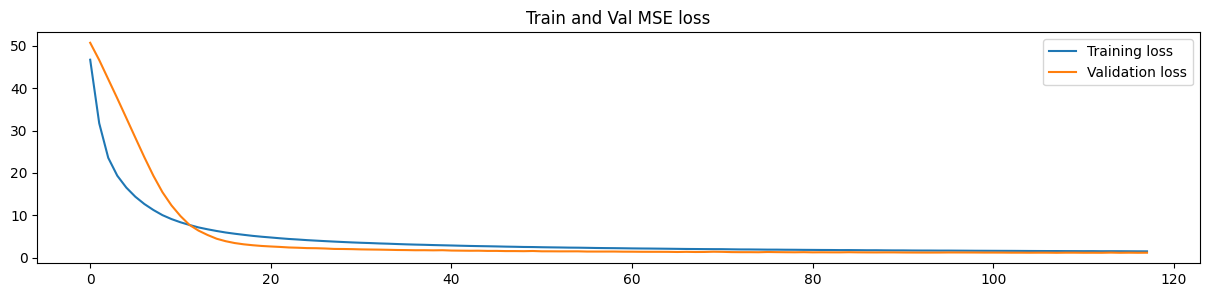

In [18]:
if __name__ == '__main__':

    model = build_network()

    model.summary()

    # you can load here your input and output data

    # X = numpy array of shape (1974,NB_MAX_LENGTH,FEATURE_NUM) of all the data input.
    # Y = numpy array of shape (1974,NB_MAX_LENGTH,OUTPUT_SIZE) of all the data labels.
    input_path = "/content/drive/MyDrive/Ex4Files/train_input.npy"
    label_path = "/content/drive/MyDrive/Ex4Files/train_labels.npy"

    X = np.load(input_path)
    Y = np.load(label_path)

    # split into validation and test sets as you like
    from sklearn.model_selection import train_test_split
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    # b)
    # compile model using Adam optimizer (with learning rate of your choice) and MSE loss.
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # EarlyStopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=[early_stop],
        verbose=1
    )


    # d)
    # save model
    model.save("/content/drive/MyDrive/Ex4Files/trained_model.keras")

    # part 3 predict
    # plot training and validation loss
    plot_val_train_loss(history)


from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Ex4Files/trained_model.h5")


In [29]:
!pip install -U keras h5py


from Bio import SeqIO
import numpy as np
from Bio.Data.IUPACData import protein_letters_1to3_extended

import importlib
importlib.reload(utils)



from keras.models import load_model  # <-- שימי לב: מייבאים מהkeras המקורי

import os
os.path.exists("/content/drive/MyDrive/Ex4Files/trained_model.keras")


model = load_model("/content/drive/MyDrive/Ex4Files/trained_model.keras")

# Load sequence from FASTA
fasta_path = "/content/drive/MyDrive/Ex4Files/6xw6/6xw6.fasta"
sequence = str(next(SeqIO.parse(fasta_path, "fasta")).seq)

# Generate input matrix from PDB
pdb_path = "/content/drive/MyDrive/Ex4Files/6xw6/6xw6.pdb"
input_matrix = utils.generate_input(pdb_path)

# Predict coordinates
predicted_coords = model.predict(input_matrix[np.newaxis, ...])[0]

# Convert predicted coordinates to PDB
output_path = "/content/drive/MyDrive/Ex4Files/6xw6/predicted_6xw6"
utils.matrix_to_pdb(sequence, predicted_coords, pdb_name=output_path)

print("✅ Prediction complete! Saved to predicted_6xw6.pdb")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Ex4Data', '6xw6', 'model_loss_history.png', 'trained_model.keras', 'utils.ipynb', 'train_labels.npy', 'train_input.npy', 'net.ipynb']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
✅ Prediction complete! Saved to predicted_6xw6.pdb
